# ***CNN***

In [1]:
import joblib
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import random
import tensorflow as tf
import time

from optuna.pruners import MedianPruner
import optuna.visualization as vis

from reporte_metricas import ReporteMetricas

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, auc, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, f1_score, log_loss, roc_auc_score, roc_curve
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder, label_binarize
)
from sklearn.utils.class_weight import compute_sample_weight

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Conv1D, Dense, Dropout, GlobalMaxPooling1D, Input, SimpleRNN
)
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical

from tqdm import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

reporte = ReporteMetricas()

In [2]:

# =======================
# LOAD DATA
# =======================
file_path = "../Saber_pro_sampled_data.csv"
df = pd.read_csv(file_path)
#df = df.head(5000)
X = df.drop(columns=["MOD_INGLES_DESEM"])
y = df["MOD_INGLES_DESEM"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
le = LabelEncoder()
y = pd.Series(le.fit_transform(y), index=y.index)

class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class mapping:", class_mapping)

Class mapping: {'-A1': np.int64(0), 'A1': np.int64(1), 'A2': np.int64(2), 'B1': np.int64(3), 'B2': np.int64(4)}


In [4]:
# ============================
# FILE PATHS
# ============================
model_filename = "../Models/best_cnn_model.pkl"
study_filename = "../Study/optuna_study_CNN_nested.pkl"
metrics_filename = "../Metrics/best_cnn_metrics.pkl"
fold_metrics_filename = "../Metrics/cnn_folds_summary.csv"

In [5]:
# Explicitly ordered categorical columns
ORDINAL_COLUMNS = {
    'FAMI_ESTRATOVIVIENDA': [
        'Sin Estrato',
        'Estrato 1',
        'Estrato 2',
        'Estrato 3',
        'Estrato 4',
        'Estrato 5',
        'Estrato 6'
    ],

    'FAMI_EDUCACIONPADRE': [
        'Ninguno',
        'Primaria incompleta',
        'Primaria completa',
        'Secundaria (Bachillerato) incompleta',
        'Secundaria (Bachillerato) completa',
        'Técnica o tecnológica incompleta',
        'Técnica o tecnológica completa',
        'Educación profesional incompleta',
        'Educación profesional completa',
        'Postgrado',
        'No sabe',
        'No Aplica'
    ],

    'FAMI_EDUCACIONMADRE': [
        'Ninguno',
        'Primaria incompleta',
        'Primaria completa',
        'Secundaria (Bachillerato) incompleta',
        'Secundaria (Bachillerato) completa',
        'Técnica o tecnológica incompleta',
        'Técnica o tecnológica completa',
        'Educación profesional incompleta',
        'Educación profesional completa',
        'Postgrado',
        'No sabe',
        'No Aplica'
    ],

    'ESTU_HORASSEMANATRABAJA': [
        '0',
        'Menos de 10 horas',
        'Entre 11 y 20 horas',
        'Entre 21 y 30 horas',
        'Más de 30 horas'
    ],

    'ESTU_VALORMATRICULAUNIVERSIDAD': [
        "No pagó matrícula",
        "Menos de 500 mil",
        "Entre 500 mil y menos de 1 millón",
        "Entre 1 millón y menos de 2.5 millones",
        "Entre 2.5 millones y menos de 4 millones",
        "Entre 4 millones y menos de 5.5 millones",
        "Entre 5.5 millones y menos de 7 millones",
        "Más de 7 millones"
    ]
}

In [6]:
class CNNWrapper:
    def __init__(self, params, numeric_features, categorical_features):
        self.params = params.copy()
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.preprocessor = self._build_preprocessor()
        self.model = None

    def _build_preprocessor(self):
        ordinal_features = [col for col in self.categorical_features if col in ORDINAL_COLUMNS]
        nominal_features = [col for col in self.categorical_features if col not in ORDINAL_COLUMNS]
        transformers = []

        for col in ordinal_features:
            order = ORDINAL_COLUMNS[col]
            transformers.append(
                (f'ord_{col}', Pipeline([
                    ('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
                    ('ord', OrdinalEncoder(categories=[order], handle_unknown='use_encoded_value', unknown_value=-1)),
                    ('scaler', MinMaxScaler())
                ]), [col])
            )

        if nominal_features:
            transformers.append(
                ('nominal', Pipeline([
                    ('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
                    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                ]), nominal_features)
            )

        return ColumnTransformer(
            transformers=transformers,
            verbose_feature_names_out=False,
            remainder='drop',
            n_jobs=-1
        )

    def _reshape_for_cnn(self, X):
        return X.reshape((X.shape[0], X.shape[1], 1))  # (samples, features, 1)

    def fit(self, X, y, eval_set=None, sample_weight=None):
        self.preprocessor = self._build_preprocessor().fit(X)
        X_proc = self.preprocessor.transform(X)
        X_seq = self._reshape_for_cnn(X_proc)
        y_cat = to_categorical(y)
        input_shape = (X_seq.shape[1], X_seq.shape[2])
        num_classes = y_cat.shape[1]

        device_name = self.params.get("device", "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0")

        with tf.device(device_name):
            self.model = Sequential()
            self.model.add(Input(shape=input_shape))
            self.model.add(Conv1D(filters=self.params['filters'], kernel_size=self.params['kernel_size'], activation='relu'))
            self.model.add(GlobalMaxPooling1D())
            self.model.add(Dropout(self.params['dropout']))
            self.model.add(Dense(num_classes, activation='softmax'))

            self.model.compile(
                optimizer=self.params['optimizer'],
                loss='categorical_crossentropy',
                metrics=[
                    'accuracy',
                    AUC(name='auc', multi_label=True, num_labels=num_classes)
                ]
            )

            callbacks = []
            if self.params.get("early_stopping", True):
                callbacks.append(EarlyStopping(monitor='val_auc', mode='max',
                                               patience=self.params.get("patience", 5),
                                               restore_best_weights=True))

            if eval_set:
                X_val, y_val = eval_set[0]
                X_val_proc = self.preprocessor.transform(X_val)
                X_val_seq = self._reshape_for_cnn(X_val_proc)
                y_val_cat = to_categorical(y_val)
            else:
                X_val_seq, y_val_cat = None, None

            self.history = self.model.fit(
                X_seq,
                y_cat,
                validation_data=(X_val_seq, y_val_cat) if eval_set else None,
                sample_weight=sample_weight,
                epochs=self.params['epochs'],
                batch_size=self.params['batch_size'],
                verbose=0,
                callbacks=callbacks
            )
        return self

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        X_seq = self._reshape_for_cnn(X_proc)
        return np.argmax(self.model.predict(X_seq), axis=1)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        X_seq = self._reshape_for_cnn(X_proc)
        return self.model.predict(X_seq)

    def save(self, path):
        self.model.save(f"{path}_model.h5")
        joblib.dump({
            "params": self.params,
            "numeric_features": self.numeric_features,
            "categorical_features": self.categorical_features,
            "preprocessor": self.preprocessor,
        }, f"{path}_meta.pkl")

    @classmethod
    def load(cls, path):
        data = joblib.load(f"{path}_meta.pkl")
        wrapper = cls(data["params"], data["numeric_features"], data["categorical_features"])
        wrapper.preprocessor = data["preprocessor"]
        wrapper.model = load_model(f"{path}_model.h5")
        return wrapper


In [7]:
# ============================
# MODEL EVALUATION
# ============================
def evaluate_model(model, X_data, y_data):
    y_pred = model.predict(X_data)
    y_proba = model.predict_proba(X_data)
    f1 = f1_score(y_data, y_pred, average='weighted')
    acc = accuracy_score(y_data, y_pred)
    loss = log_loss(y_data, y_proba)
    auc = roc_auc_score(y_data, y_proba, multi_class='ovr', average='weighted')
    report = classification_report(y_data, y_pred)
    cm = confusion_matrix(y_data, y_pred)
    return f1, acc, loss, auc, report, cm, y_proba, y_pred

In [8]:
# ============================
# LIME EXPLAINER BUILDER
# ============================
def get_lime_explainer(model_wrapper, X_train_raw, y_train_raw):
    """
    LIME explainer builder for MLP model wrapper (TensorFlow).
    """
    X_transformed = model_wrapper.preprocessor.transform(X_train_raw)
    feature_names = model_wrapper.preprocessor.get_feature_names_out()
    class_names = np.unique(y_train_raw).astype(str)

    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_transformed,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    return explainer, X_transformed



In [9]:
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=50):
    def objective(trial):
        params = {
            "filters": trial.suggest_int("filters", 32, 128, step=32),
            "kernel_size": trial.suggest_int("kernel_size", 2, 5),
            "dropout": trial.suggest_float("dropout", 0.1, 0.5),
            "optimizer": trial.suggest_categorical("optimizer", ["adam", "rmsprop", "sgd"]),
            "epochs": trial.suggest_int("epochs", 10, 70),
            "batch_size": trial.suggest_int("batch_size", 32, 256, log=True),
            "early_stopping": True,
            "patience": trial.suggest_int("patience", 5, 15)
        }

        model = CNNWrapper(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = []

        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            sample_weights = compute_sample_weight("balanced", y_t)

            model.fit(X_t, y_t, eval_set=[(X_v, y_v)], sample_weight=sample_weights)
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))

        return np.mean(scores)

    study = optuna.create_study(direction="maximize", pruner=MedianPruner())
    study.optimize(objective, n_trials=n_trials, n_jobs=1)
    return study.best_params, study


In [10]:
# ============================
# FOLD METRIC SAVER
# ============================
def save_metrics_folds(folds_metrics: list, filename: str) -> pd.DataFrame:
    df = pd.DataFrame(folds_metrics)
    metric_cols = df.columns.drop('fold') if 'fold' in df.columns else df.columns
    mean_row = df[metric_cols].mean().to_dict()
    std_row = df[metric_cols].std().to_dict()
    mean_row['fold'] = 'mean'
    std_row['fold'] = 'std'
    df_final = pd.concat([df, pd.DataFrame([mean_row, std_row])], ignore_index=True)
    df_final.to_csv(filename, index=False)
    print(f"\n📁 Fold metrics + summary saved to: {filename}")
    return df_final

# ============================
# CONFUSION MATRIX PLOTTER
# ============================
def plot_confusion_matrix(cm, labels, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

In [11]:

# ============================
# NESTED CV
# ============================
def nested_cv(X: pd.DataFrame, y: pd.Series, numeric_features: list, categorical_features: list):
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y), 1), total=outer_cv.get_n_splits(), desc="Training folds"):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold, test_size=0.2, stratify=y_train_fold, random_state=SEED
        )

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time

        optuna_studies.append(study)

        model = CNNWrapper(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    df_folds = save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig


    return best_model, best_metrics, study_dt, visualizations

In [12]:
model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)

In [13]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1523
           1       0.00      0.00      0.00      3457
           2       0.40      0.95      0.57      6269
           3       0.37      0.11      0.17      3585
           4       0.60      0.26      0.36      1645

    accuracy                           0.41     16479
   macro avg       0.28      0.26      0.22     16479
weighted avg       0.30      0.41      0.29     16479



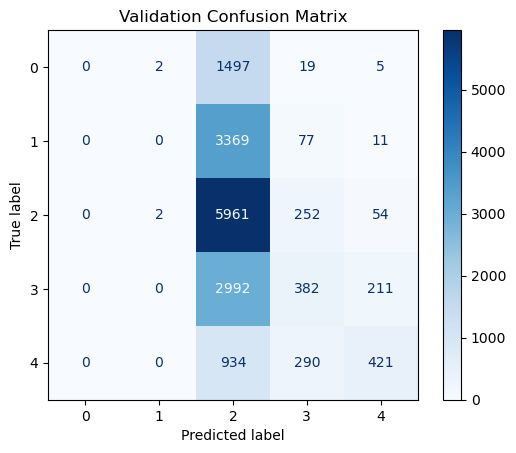

In [14]:
plot_confusion_matrix(metrics['confusion_matrix_val'], metrics['labels'], "Validation Confusion Matrix")

In [15]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1903
           1       0.50      0.00      0.00      4321
           2       0.40      0.95      0.57      7836
           3       0.37      0.11      0.17      4482
           4       0.56      0.23      0.32      2056

    accuracy                           0.41     20598
   macro avg       0.37      0.26      0.21     20598
weighted avg       0.40      0.41      0.28     20598



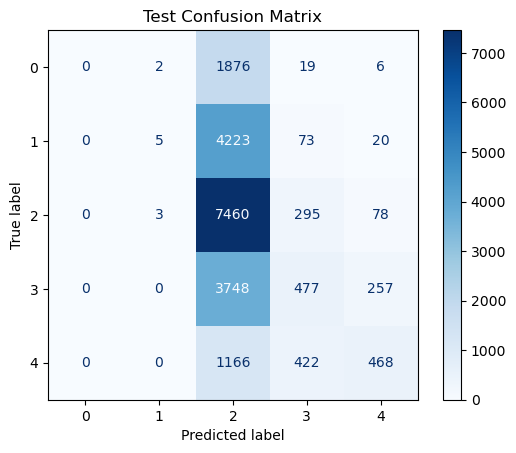

In [16]:
plot_confusion_matrix(metrics['confusion_matrix_test'], metrics['labels'], "Test Confusion Matrix")

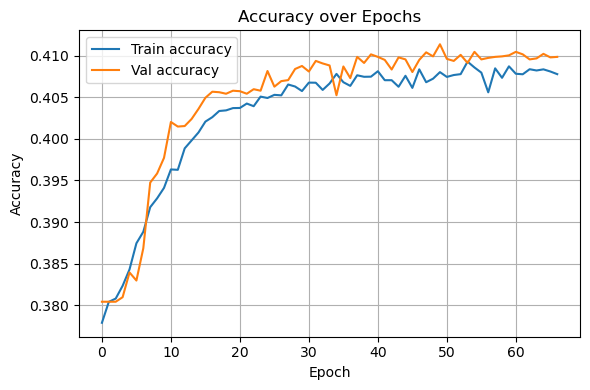

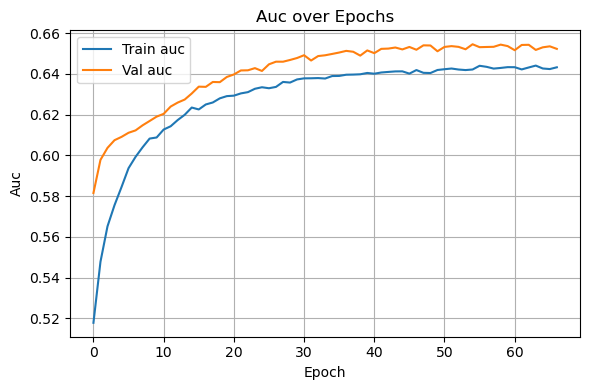

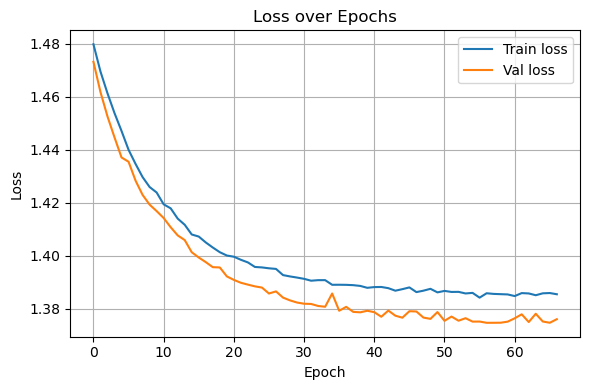

In [17]:
import matplotlib.pyplot as plt

def plot_all_metrics(history_dict):
    available_metrics = [m for m in history_dict.keys() if not m.startswith('val_')]
    
    for metric in available_metrics:
        val_metric = f'val_{metric}'
        if val_metric in history_dict:
            plt.figure(figsize=(6, 4))  # más pequeño
            plt.plot(history_dict[metric], label=f'Train {metric}')
            plt.plot(history_dict[val_metric], label=f'Val {metric}')
            plt.title(f'{metric.capitalize()} over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
plot_all_metrics(model.history.history)

In [18]:
visualizations['optimization_history']

In [19]:
visualizations['parallel_coordinate']

In [20]:
visualizations['f1_score_evolution']

In [21]:
visualizations['param_importances']

In [41]:
reporte.save(metrics, model_name="CNN")

/Users/sergiosilveramurcia/Conda/miniconda3/envs/TM4/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



/Users/sergiosilveramurcia/Conda/miniconda3/envs/TM4/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/sergiosilveramurcia/Conda/miniconda3/envs/TM4/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/sergiosilveramurcia/Conda/miniconda3/envs/TM4/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/sergiosilveramurcia/Conda/miniconda3/envs/TM4/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWa


Report for model 'CNN' saved:
   → CSV: ../Metrics/Metrics_CNN.csv
   → JSON: ../Metrics/Metrics_CNN.json


/Users/sergiosilveramurcia/Conda/miniconda3/envs/TM4/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/sergiosilveramurcia/Conda/miniconda3/envs/TM4/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [23]:
df = reporte.load()


Loaded 19 report(s):
   → Models: ['SVC_RFF', 'XGBOOST_HIST', 'LSTM', 'NB_Partial', 'SVC_lin', 'CNN', 'RF', 'SVC_SGD', 'KNN_OPT', 'RNN', 'Mult_NB', 'KNN', 'CART_SMOTE', 'Bern_NB', 'CART_ADASYN', 'MLP', 'RL', 'CART', 'XGBOOST_EARLY']
   → Types : ['train', 'val', 'test']


In [24]:
df.query("Model == 'CNN' and Type != 'train'").reset_index(drop=True)

,Model,Type,Class,precision,recall,f1-score,support,accuracy,log_loss,auc
0,CNN,val,0,0.0,0.0,0.0,1523.0,-,-,-
1,CNN,val,1,0.0,0.0,0.0,3457.0,-,-,-
2,CNN,val,2,0.404,0.951,0.567,6269.0,-,-,-
3,CNN,val,3,0.375,0.107,0.166,3585.0,-,-,-
4,CNN,val,4,0.6,0.256,0.359,1645.0,-,-,-
5,CNN,val,macro avg,0.276,0.263,0.218,16479.0,-,-,-
6,CNN,val,weighted avg,0.295,0.41,0.288,16479.0,-,-,-
7,CNN,val,global,-,-,-,-,0.41,1.375,0.626
8,CNN,test,0,0.0,0.0,0.0,1903.0,-,-,-
9,CNN,test,1,0.5,0.001,0.002,4321.0,-,-,-


In [25]:
def plot_roc_multiclass(y_true, y_proba, class_labels, title="AUC-ROC Curve (Multiclass)"):
    # Binarize true labels
    y_bin = label_binarize(y_true, classes=class_labels)
    n_classes = len(class_labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"Class {class_labels[i]} (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


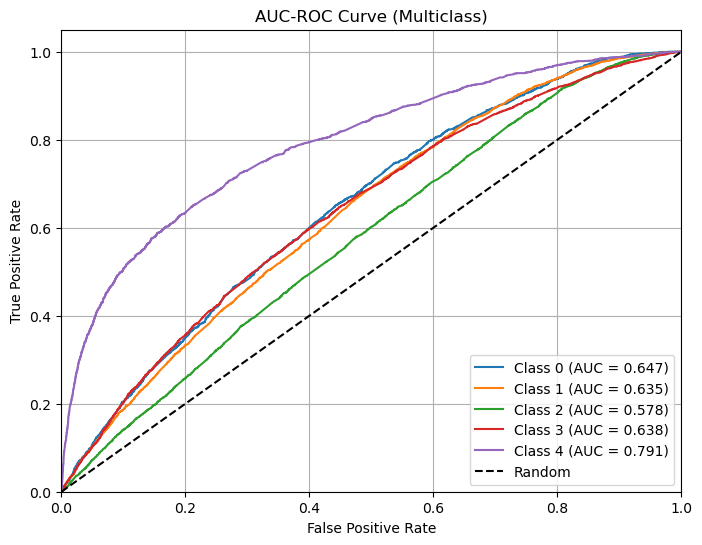

In [26]:
plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
    class_labels=metrics["labels"]
)

In [27]:
model.params

{'filters': 128,
 'kernel_size': 5,
 'dropout': 0.1472379962870281,
 'optimizer': 'adam',
 'epochs': 67,
 'batch_size': 165,
 'patience': 12}

In [28]:
model.model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,241 (16.57 KB)

 Trainable params: 1,413 (5.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,828 (11.05 KB)

In [29]:
for layer in model.model.layers:
    print(f"Layer: {layer.name}")
    weights = layer.get_weights()
    print(f" - Num weight arrays: {len(weights)}")
    for i, w in enumerate(weights):
        print(f"   Shape[{i}]: {w.shape}")


Layer: conv1d_1
 - Num weight arrays: 2
   Shape[0]: (5, 1, 128)
   Shape[1]: (128,)
Layer: global_max_pooling1d_1
 - Num weight arrays: 0
Layer: dropout_1
 - Num weight arrays: 0
Layer: dense_1
 - Num weight arrays: 2
   Shape[0]: (128, 5)
   Shape[1]: (5,)
